# Explore here

In [1]:
# LIBRERIAS
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, f_oneway
import sklearn

In [2]:
total_data = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/linear-regression-project-tutorial/main/medical_insurance_cost.csv")
total_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
total_data.shape

(1338, 7)

In [4]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Vemos lo que contiene nuestro Dataframe son variables de tipo Float 2 de tipo entero 2 y objeto o string 3

In [5]:
total_data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Aqui verificamos que el dataframe no contenga algun valor nulo.

In [6]:
total_data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


Verificaremos que no existan valores duplicados


In [7]:
total_data.duplicated().sum()
total_data = total_data.drop_duplicates().reset_index(drop = True)
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.2+ KB


Dividiremos las variables en numericas y categoricas

In [8]:
num_cols = total_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = total_data.select_dtypes(include=['object']).columns.tolist()

print("Numéricas:", num_cols)
print("Categóricas:", cat_cols)

Numéricas: ['age', 'bmi', 'children', 'charges']
Categóricas: ['sex', 'smoker', 'region']


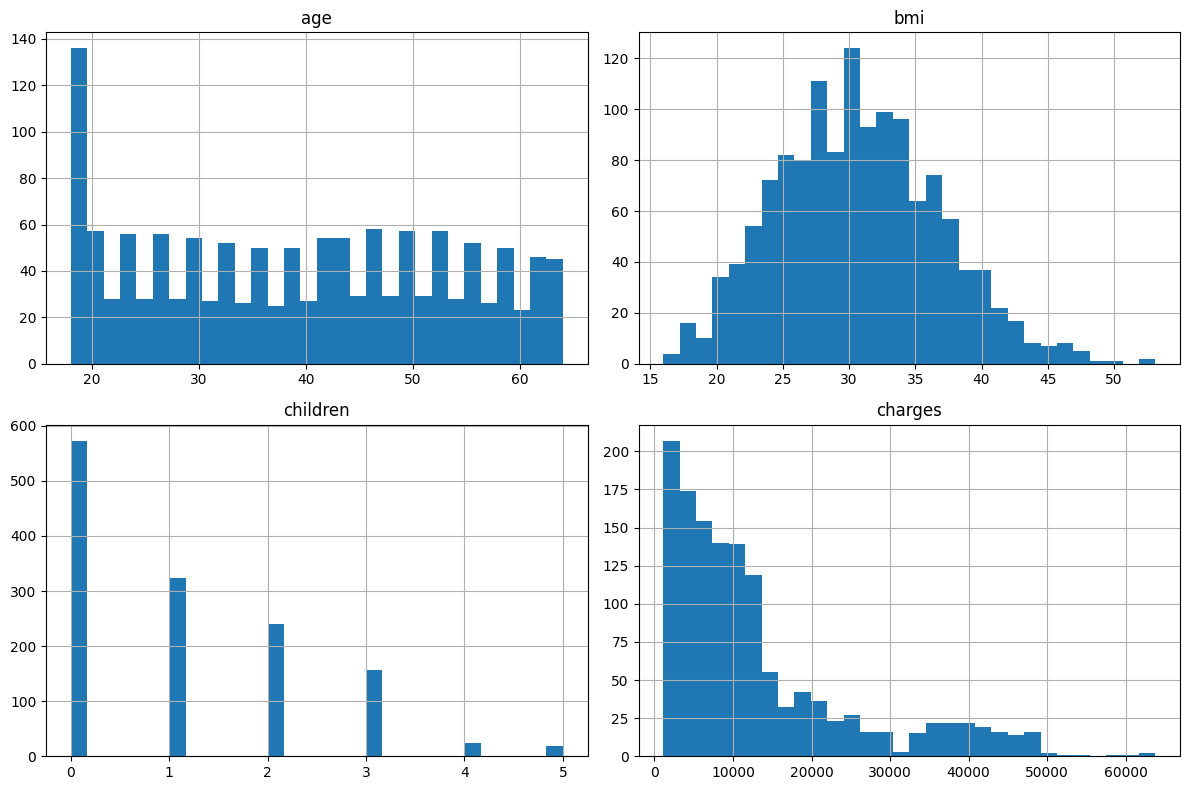

In [9]:
# Histogramas de variables numéricas
total_data[num_cols].hist(figsize=(12,8), bins=30)
plt.tight_layout()
plt.show()



ANALISIS MULTIVARIABLE

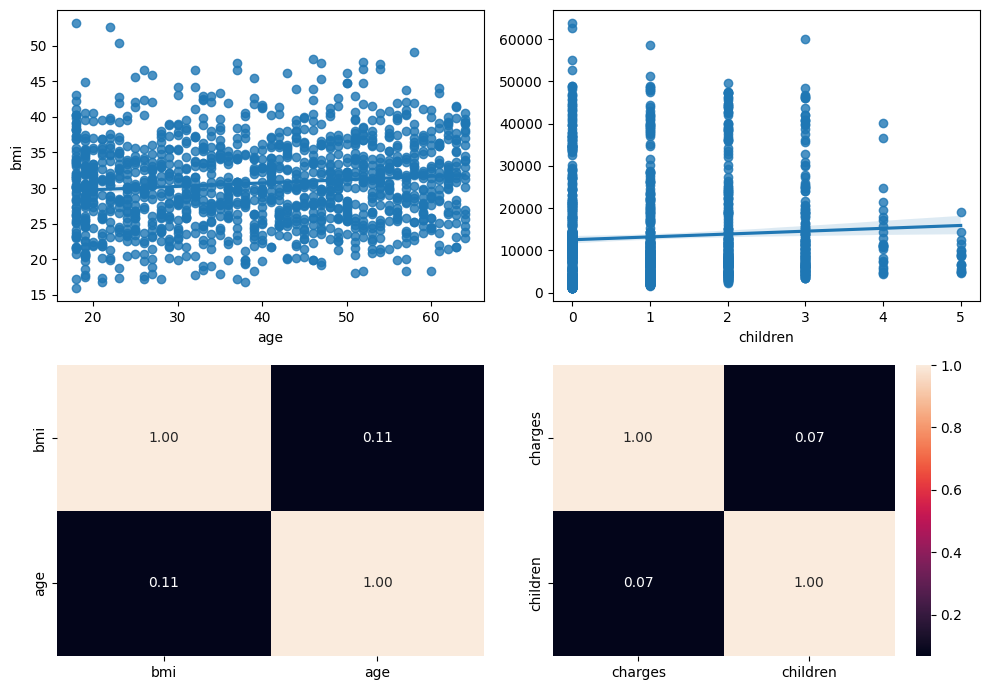

In [10]:
fig, axis = plt.subplots(2, 2, figsize = (10, 7))

# Crear un diagrama de dispersión múltiple
sns.regplot(ax = axis[0, 0], data = total_data, x = "age", y = "bmi")
sns.heatmap(total_data[["bmi", "age"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 0], cbar = False)
sns.regplot(ax = axis[0, 1], data = total_data, x = "children", y = "charges").set(ylabel=None)
sns.heatmap(total_data[["charges", "children"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 1])

# Ajustar el layout
plt.tight_layout()

# Mostrar el plot
plt.show()



vamos a analizar la correlacion entre variables categoricas ya que entre variables numericas no existe una correlacion visible .

In [11]:
cat_vars = total_data.select_dtypes(include=['object']).columns

# Tabla de contingencia y Chi-cuadrado para cada par
for i in range(len(cat_vars)):
    for j in range(i+1, len(cat_vars)):
        table = pd.crosstab(total_data[cat_vars[i]], total_data[cat_vars[j]])
        chi2, p, dof, expected = chi2_contingency(table)
        print(f"{cat_vars[i]} vs {cat_vars[j]} -> p-value: {p:.4f}")

sex vs smoker -> p-value: 0.0063
sex vs region -> p-value: 0.9239
smoker vs region -> p-value: 0.0635


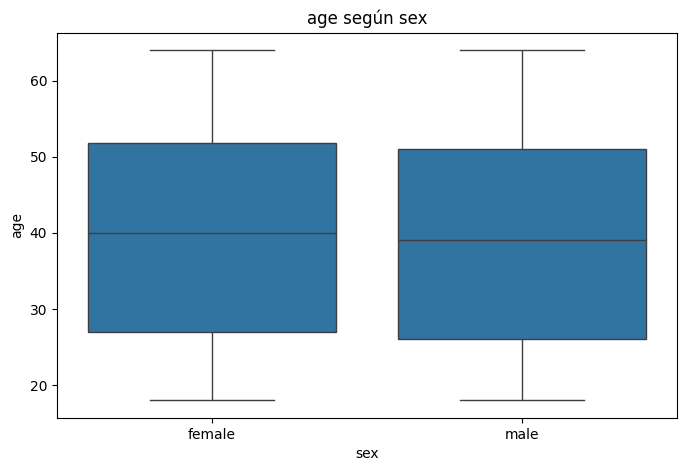

ANOVA age ~ sex -> p-value: 0.4691


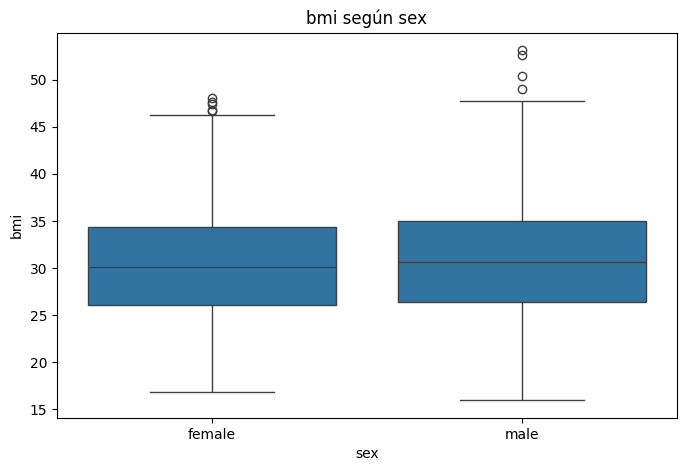

ANOVA bmi ~ sex -> p-value: 0.0899


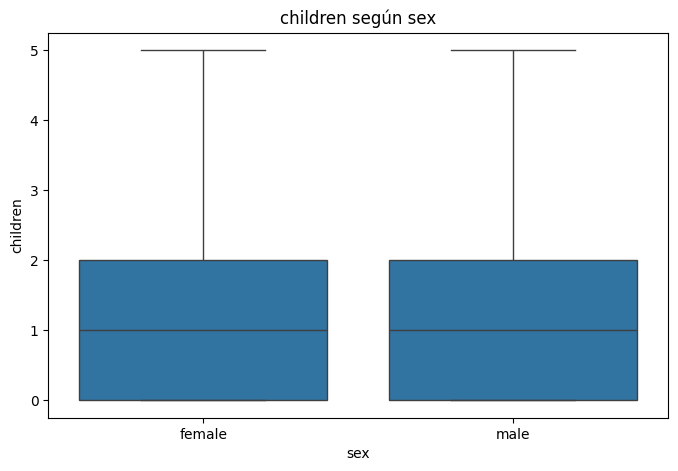

ANOVA children ~ sex -> p-value: 0.5144


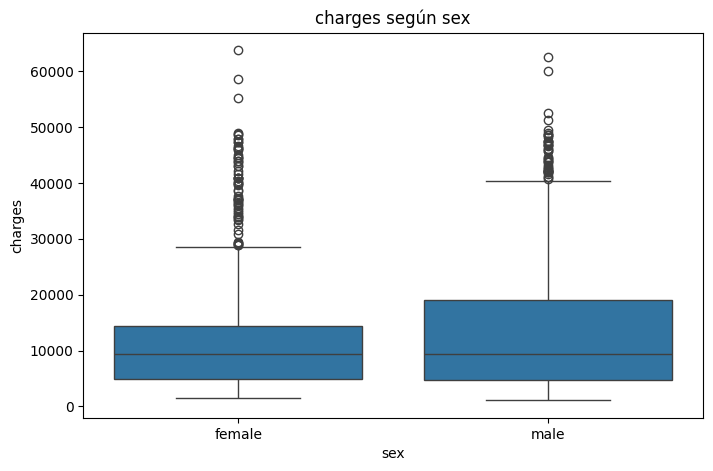

ANOVA charges ~ sex -> p-value: 0.0338


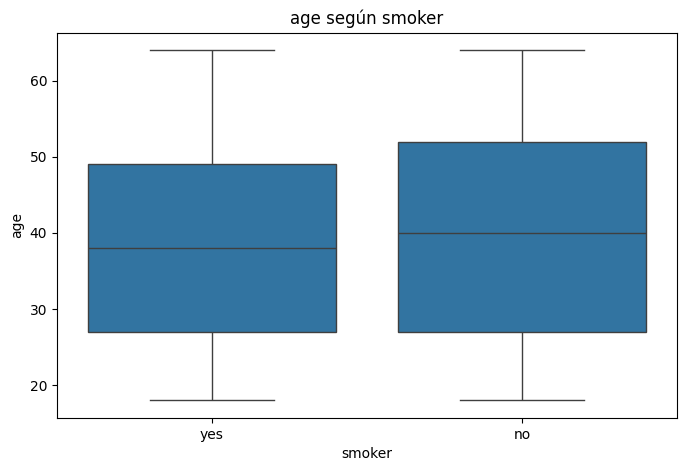

ANOVA age ~ smoker -> p-value: 0.3499


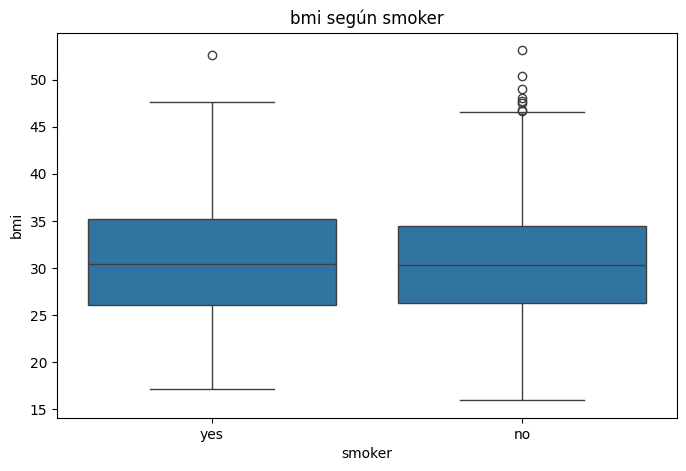

ANOVA bmi ~ smoker -> p-value: 0.8911


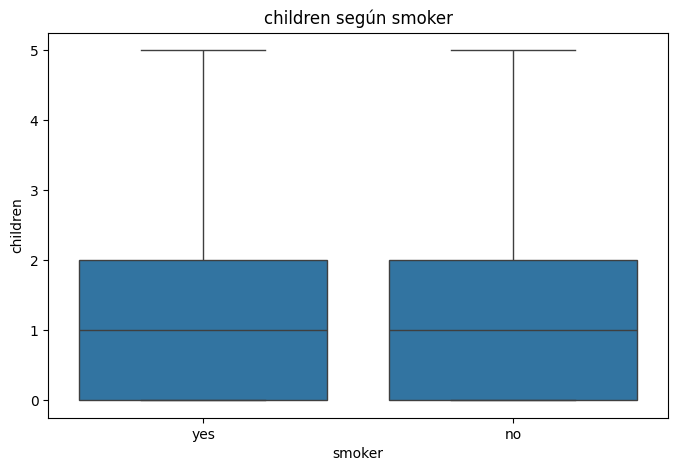

ANOVA children ~ smoker -> p-value: 0.7888


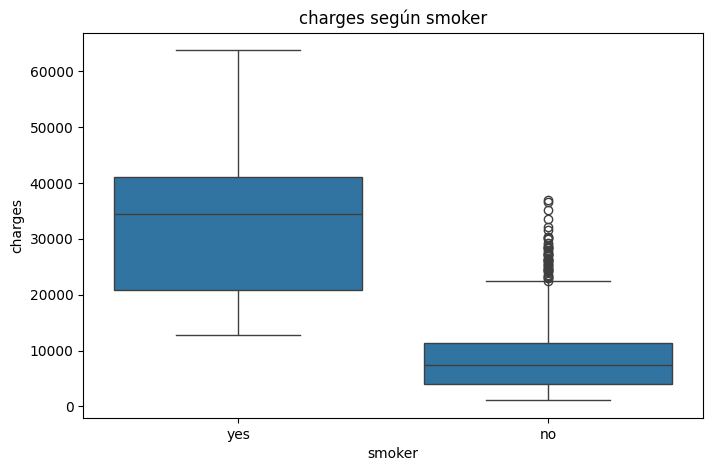

ANOVA charges ~ smoker -> p-value: 0.0000


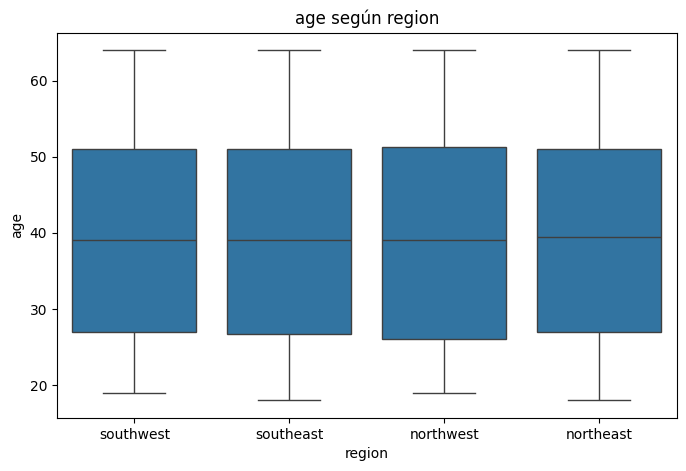

ANOVA age ~ region -> p-value: 0.9705


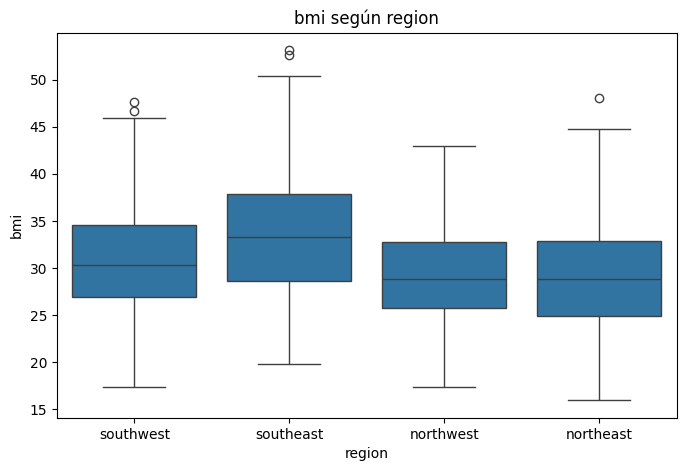

ANOVA bmi ~ region -> p-value: 0.0000


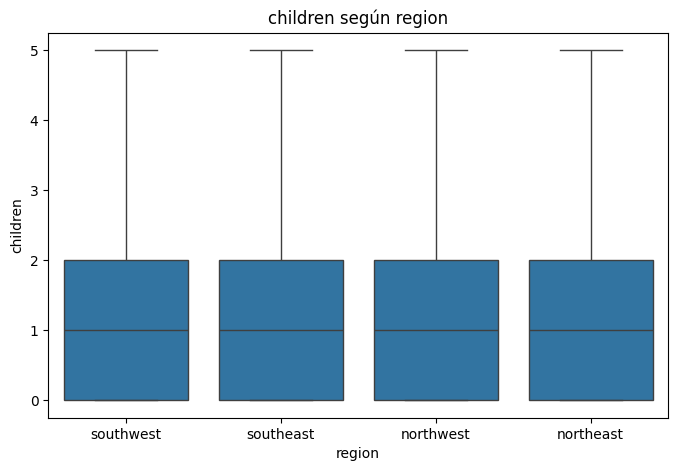

ANOVA children ~ region -> p-value: 0.5251


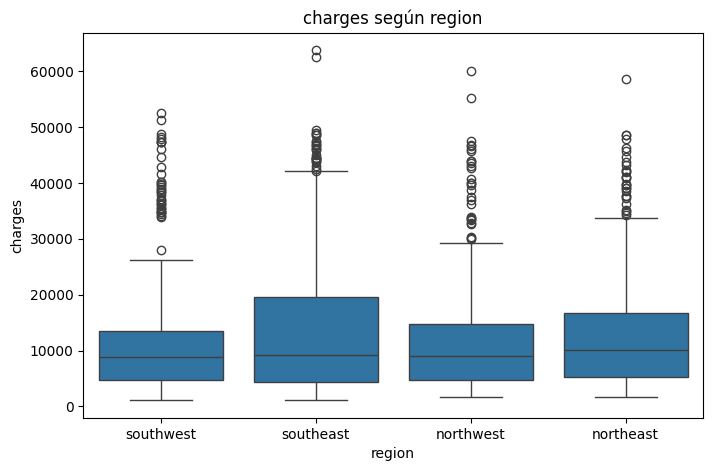

ANOVA charges ~ region -> p-value: 0.0328


In [12]:
num_vars = total_data.select_dtypes(include=['int64','float64']).columns
for cat in cat_vars:
    for num in num_vars:
        plt.figure(figsize=(8,5))
        sns.boxplot(x=cat, y=num, data=total_data)
        plt.title(f"{num} según {cat}")
        plt.show()

        # ANOVA para ver si hay diferencias significativas
        grupos = [total_data[total_data[cat] == nivel][num] for nivel in total_data[cat].unique()]
        stat, p = f_oneway(*grupos)
        print(f"ANOVA {num} ~ {cat} -> p-value: {p:.4f}")

Pudimos encontrar una correlacion muy alta entre la Edad y la Region de los datos del Dataframe

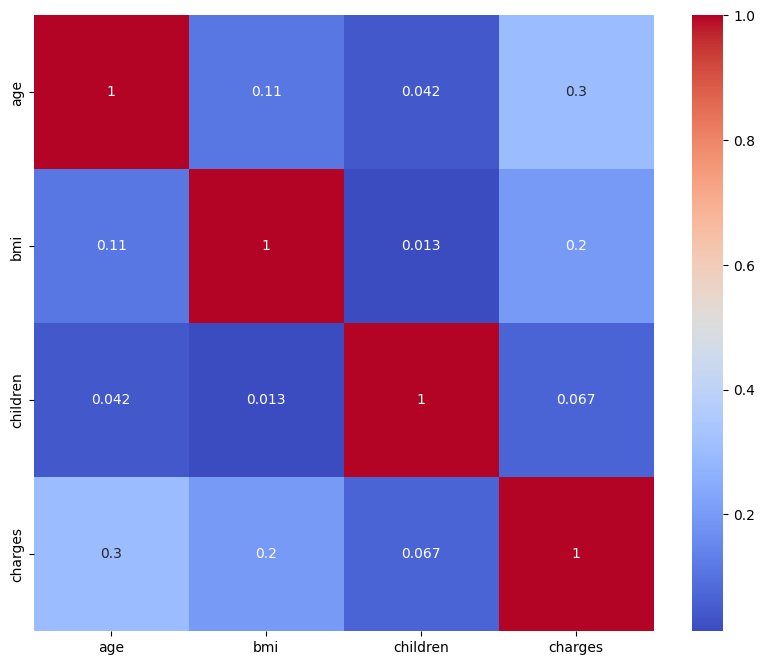

In [13]:
plt.figure(figsize=(10,8))
corr = total_data[num_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()

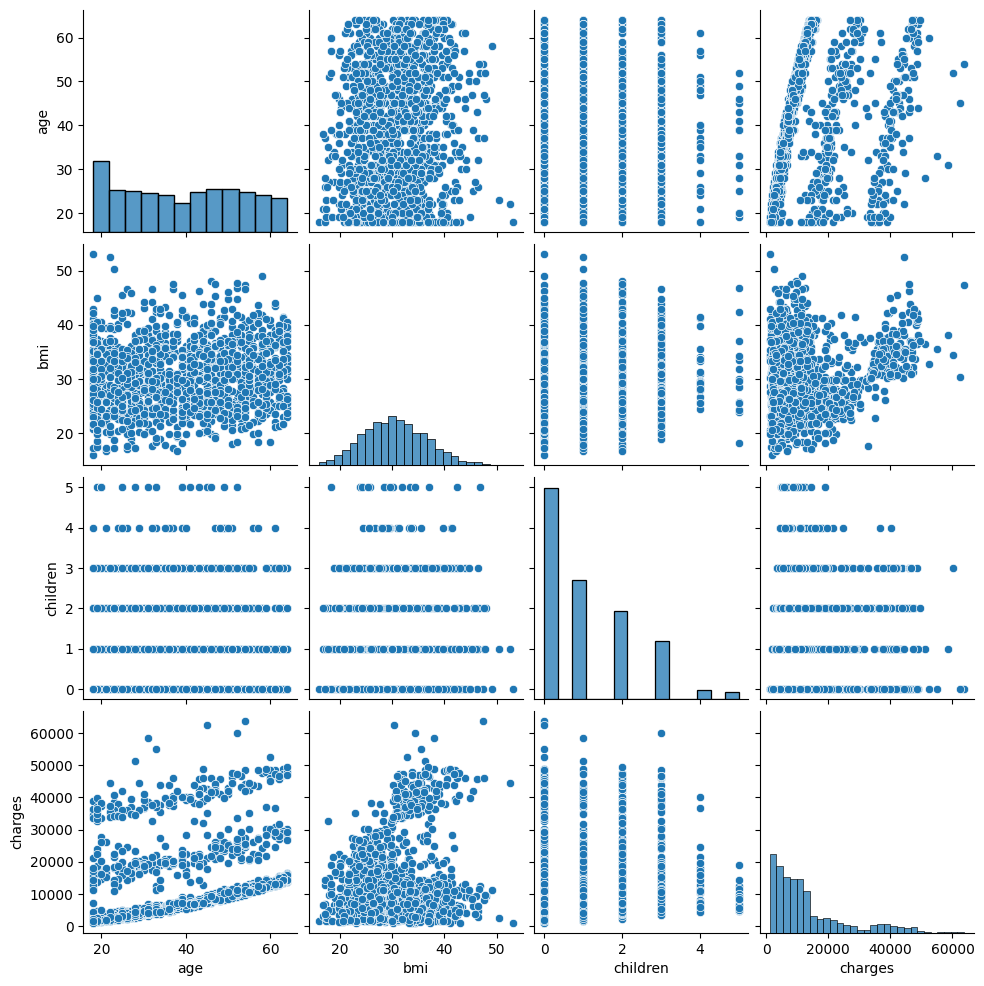

In [14]:
sns.pairplot(data = total_data)

Vamos a proceder con la Deteccion de Outliers

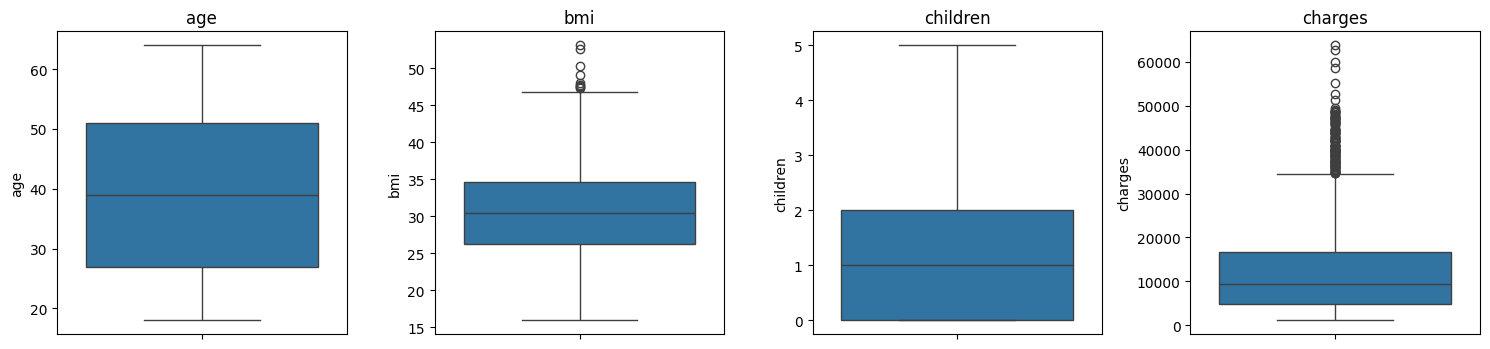

In [15]:
plt.figure(figsize=(15,10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 4, i)  # Ajustar filas/columnas según cantidad de variables
    sns.boxplot(y=total_data[col])
    plt.title(col)
plt.tight_layout()
plt.show()

In [16]:
num_cols = total_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Guardar copia del dataset original
total_data_original = total_data.copy()

# Crear copia para limpiar
total_data_clean = total_data.copy()
# Revisión de outliers por IQR
for col in num_cols:
    Q1 = total_data[col].quantile(0.25)
    Q3 = total_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    outliers_count = ((total_data[col] < lower_limit) | (total_data[col] > upper_limit)).sum()
    print(f"{col}: {outliers_count} outliers")

    # Winsorización → recorte de valores extremos
    total_data_clean[col] = total_data_clean[col].clip(lower_limit, upper_limit)
    

age: 0 outliers
bmi: 9 outliers
children: 0 outliers
charges: 139 outliers


In [17]:

from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif



# 1️⃣ Variable objetivo
y = total_data_clean["charges"]  # Aquí usamos la columna 'charges' que dice si el cliente contrató el producto
X = total_data_clean.drop(columns=["charges"])  # El resto de columnas como variables predictoras

# 2️⃣ Convertir variables categóricas a numéricas
X = pd.get_dummies(X, drop_first=True)

# 3️⃣ Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4️⃣ Seleccionar las 15 mejores variables
selector = SelectKBest(score_func=f_classif, k=15)
selector.fit(X_train, y_train)

# 5️⃣ Columnas seleccionadas
selected_columns = X_train.columns[selector.get_support()]
print("Variables seleccionadas:", selected_columns.tolist())

# 6️⃣ DataFrames con solo las variables seleccionadas
X_train_sel = X_train[selected_columns]
X_test_sel = X_test[selected_columns]

Variables seleccionadas: ['age', 'bmi', 'children', 'sex_male', 'smoker_yes', 'region_northwest', 'region_southeast', 'region_southwest']


C:\Users\isaac\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=15 is greater than n_features=8. All the features will be returned.
  warnings.warn(


iniciamos el modelo de regresion lineal

In [18]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [19]:
print(f"Intercepto (a): {model.intercept_}")
print(f"Coeficientes (b): {model.coef_}")

Intercepto (a): -6984.617718291596
Coeficientes (b): [  223.62247052   217.0895234    462.96932106  -217.72872648
 19660.9818596   -246.73250121  -710.06653609  -535.87686523]


In [20]:
y_pred = model.predict(X_test)
y_pred

array([ 8642.92522983,  6373.92614472, 13461.10604889, 27998.81617251,
        8279.88905058, 12114.05473926, 26706.29242838,  2674.47518644,
       10121.12191283, 11125.62849881, 10988.03853045, 29779.84074065,
       27378.24446433, 15672.41514753, 10038.1327858 ,  9481.19582689,
        4361.14969357, 27903.49836204,  4146.9212701 ,  5677.01570905,
        3941.71942814, 27055.94756773, 13454.13630172, 27250.63773298,
       27522.36393352,  5691.3809754 , 31048.28406866, 32460.64314804,
       11117.86818828, 13117.22369534,  6691.56491212, 11779.18849842,
        1638.28849517, 11888.43366497, 34313.50181274, 11771.68243411,
        5251.93933082,  5197.16785098, 28137.73085512,  9144.27984177,
        6576.325112  , 27569.62851215, 30561.95323079, 11677.3604784 ,
        8312.15805816,  4341.84429464,  5784.95275355,  9049.21771937,
        5123.26506538,  8755.47719813,  6656.63783439, 10778.88352596,
       28240.95195086,  3795.63024438, 10351.66403149,  9515.39183709,
      

Para calcular la efectividad del modelo utilizaremos el error cuadrático medio (MSE) y el coeficiente de determinación (
r2)

In [21]:
from sklearn.metrics import mean_squared_error, r2_score

print(f"Error cuadrático medio: {mean_squared_error(y_test, y_pred)}")
print(f"Coeficiente de determinación: {r2_score(y_test, y_pred)}")

Error cuadrático medio: 20905443.470454138
Coeficiente de determinación: 0.8210971615394599
